# **Knowledge Graph based on ontology from Python Source code**
Experiments on SNIPS-NLU Project. Mount your google drive and put the project file into your MyDrive folder...
______________________________________________________
The first cell is for google drive mounting and installing dependencies and libraries.

In [ ]:
from google.colab import drive
snips_nlu_path = '/content/drive/MyDrive/snips_nlu'
drive.mount('/content/drive')
%cd /content/drive/MyDrive/snips_nlu
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install rdflib
!pip install ontospy
!pip install owlready2



In [ ]:
%tensorflow_version 1.x
%cd /content/drive/MyDrive/snips_nlu

TensorFlow 1.x selected.
/content/drive/MyDrive/snips_nlu


Started Parsing


Number of files parsing:  9
Term Extraction with Model training...
Loading Labeled Corpus...


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Term Extraction Model Summary...
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 185)               0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 185, 150)          56700     
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 185, 300)          361200    
_________________________________________________________________
lstm_48 (LSTM)               (None, 185, 300)          721200    
_________________________________________________________________
time_distributed_24 (TimeDis (None, 185, 6)            1806      
_________________________________________________________________
crf_24 (CRF)                 (None, 185, 6)            90        
Total params: 1,140,996
Trainable params: 1,140,996
Non-trainable params: 0
_______________

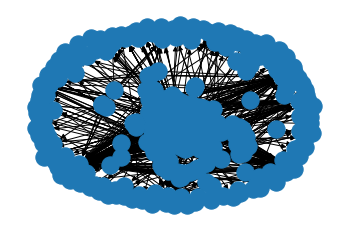

In [ ]:
import sys
import json as json
import ast
import os
import io
import glob
from csv import writer 
import pandas as pd
import ontospy
################################################################################
#Parse and Tag 
################################################################################

TermsExtracted = []
code_index=0
def ExtractAllTerms(tree, code_index):
    code_ind = str(code_index)
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            TermsExtracted.append(code_ind + ", " + node.name + ", Method," + " MTD")
        if isinstance(node, ast.ClassDef):
            TermsExtracted.append(code_ind + ", " + node.name + ", ClASS," + " C")
        elif isinstance(node, ast.Num):
            TermsExtracted.append(code_ind + ", " + str(node.n) + ", Number," + " Num")
        elif isinstance(node, ast.Str):
            TermsExtracted.append(code_ind + ", " + node.s + ", String," + " STR")
        elif isinstance(node, ast.Call):
            func_class = node.func
            if(func_class.__class__.__name__ == 'Name'):
                TermsExtracted.append(code_ind + ", " + func_class.id + ", Func_Call," + " FC")
        elif isinstance(node, ast.Call):
            func_class = node.func
            if(func_class.__class__.__name__ == 'Attribute'):
                TermsExtracted.append(code_ind +", " + func_class.attr + ", Attribute," + " ATT")
        elif isinstance(node, ast.Import):
            Import_class = node.names
            if(Import_class != None):
                lib = Import_class[0]
                lib_name = lib.name
                TermsExtracted.append(code_ind + ", " + lib_name + ", Library," + " LIB")

    
fileList = glob.glob('Raw_code_files/*.py')
print("Started Parsing\n\n")
print("Number of files parsing: ",len(fileList))
   
TermsExtracted = []
path = 'Raw_code_files'
files = os.listdir(path)

for file in fileList:
    with open(file, "r") as source:
       tree = ast.parse(source.read())
       ExtractAllTerms(tree, code_index)
# for filePath in fileList:
#     # try:
#       with open(filepath, "r") as source:
#           tree = ast.parse(source.read())
#           ExtractAllTerms(tree, code_index)
    # except:
    #   print("Error while parsing file : ", filePath)
        
with open('TermsExtracted.csv', 'w') as filehandle:
  for listitem in TermsExtracted:
    filehandle.write('%s\n' % listitem)


################################################################################
# Term Extraction
################################################################################
print("Term Extraction with Model training...")
print("Loading Labeled Corpus...")


df = pd.read_csv("Labeled_data_terms.csv", encoding="utf-8", sep=',')
# df.head(10)
data = df[['code_index','word','label']]

class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["label"].values.tolist())]
        self.grouped = self.dataset.groupby("code_index").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
          
getter = SentenceGetter(data)
sentences = getter.sentences  

from math import nan

words = list(set(data["word"].values))
n_words = len(words)
tags = []
for tag in set(data["label"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('O')
    else:
        tags.append(tag)
n_tags = len(tags)

from future.utils import iteritems

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

maxlen = max([len(s) for s in sentences])

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split


maxlen = max([len(s) for s in sentences])

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag2idx[t[1]] for t in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=n_tags-1)
y = [to_categorical(i, num_classes=n_tags) for i in y]

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF

input = Input(shape=(maxlen,))
word_embedding_size = 150

# Embedding Layer
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(input)

# BI-LSTM Layer
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)

# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  

# CRF Layer
crf = CRF(n_tags)

out = crf(model)  # output
model = Model(input, out)

from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import add
#Optimiser 
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
print("Term Extraction Model Summary...")
model.summary()

# Saving the best model only
filepath="saved_model/termext-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

print("Training the model in 20 Epochs...")
# history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=20, validation_split=0.2, verbose=1, callbacks=callbacks_list)

i = 0
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
gt = np.argmax(y_test[i], axis=-1)

print("Classifying and testing the model...\n\n")
print("Writing classified terms to file...\n\n")
# print("{:14}, {}".format("Word", "Pred"))
# for idx, (w,pred) in enumerate(zip(X_test[i],p[0])):
#     print("{:14},  {}".format(words[w],tags[pred]))
with open('TermsPredicted.csv', 'w') as f:
  for idx, (w,pred) in enumerate(zip(X_test[i],p[0])):
    f.write("{:14}, {:5}, {}\n".format(words[w],idx2tag[gt[idx]],tags[pred]))
f.close()
######################################################################################
#Concept Extraction
######################################################################################
print("Extracting Concepts based on tag classes...\n\n")
colnames=['word', 'label', 'pred'] 
csv_data = pd.read_csv("TermsPredicted.csv", header = None, names=colnames, encoding="utf-8", sep=',')
# df = pd.read_csv("TermsPredicted.csv", encoding="utf-8", sep=',')
data = csv_data[['word','label']]
agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["label"].values.tolist())]
concepts = data['label'].unique()
# for item in concepts:
#         print(item)
with open('Concepts.csv', 'w') as filehandle:
  for i in concepts:
    filehandle.write(i+"\n")
# concepts = data.groupby("label").apply(agg_func)
# with open('Concepts.csv', 'w') as filehandle:
#   for i in concepts:
#     for j in i:
#       for k in j:
#         filehandle.write(k+"\n")
######################################################################################
#Relation Extraction
######################################################################################
print("Extracting Relations...")
df = pd.read_csv("Relation_data.csv", encoding="utf-8", sep=',')
# df['relation'].value_counts()
data = df[['code_index','word','label','relation']]
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["relation"].values.tolist())]
        self.grouped = self.dataset.groupby("code_index").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
          
getter = SentenceGetter(data)
sentences = getter.sentences  
from math import nan

words = list(set(data["word"].values))
n_words = len(words)
tags = []
for tag in set(data["relation"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('O')
    else:
        tags.append(tag)
n_tags = len(tags)
from future.utils import iteritems

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}
# print(tag2idx)
maxlen = max([len(s) for s in sentences])


X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag2idx[t[1]] for t in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=n_tags-1)
y = [to_categorical(i, num_classes=n_tags) for i in y]

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

input = Input(shape=(147,))
word_embedding_size = 150
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF

# Embedding Layer
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=147)(input)

# BI-LSTM Layer
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)

# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  

# CRF Layer
crf = CRF(n_tags)

out = crf(model)  # output
model = Model(input, out)
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import add
#Optimiser 
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
print("relation Extraction Model Summary...")
model.summary()

# Saving the best model only
filepath="saved_model/Relext-bi-lstm-td-model-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=20, validation_split=0.2, verbose=1, callbacks=callbacks_list)

######################################################################################
#Knowledge Graph Creation
######################################################################################
print("Creating RDF Triples\n\n")
from rdflib import Graph, Literal, Namespace, URIRef
from rdflib.namespace import RDF, FOAF, RDFS, OWL
import pandas as pd
import io
g = Graph()
ex = Namespace("http://example.org/SnipsNLUProject/")
g.bind("ex", ex)
# colnames=['code_index','word', 'label', 'tag'] 
csv_data = pd.read_csv("Tordf.csv", encoding="utf-8", sep=',')
csv_data = csv_data.fillna("unknown")

for index, row in csv_data.iterrows():
    subject = row['word']
    predicate = row['relation']
    object1 = row['label']

    # Create triples: e.g. "Cade_Tracey - age - 27"
    g.add((URIRef(row['Subject_URI']), RDFS.domain, Literal(row['word'], lang='en')) )
    g.add((URIRef(row['Predicate_URI']), RDFS.label, Literal(row['relation'], lang='en')) )
    g.add((URIRef(row['Object_URI']), RDFS.range, Literal(row['label'], lang='en')) )
print("Writing RDF triples to File named kgrdf.rdf...\n\n")
with open('kgrdf.rdf', 'w') as filehandle:
  filehandle.write(g.serialize(format="xml").decode())


##############################################################################
# Knowledge Graph VISUALIZATIONS
##############################################################################
print("Visualizing the rdf file using node and edge png format(this is not interactive)...\n\n")
print("Visualization Can Be Done in Many ways, \ndownload kgrdf file and visualize by any rdf visualization tools of your choice...")
import rdflib
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
import matplotlib.pyplot as plt
url = 'kgrdf.rdf'
g = rdflib.Graph()
result = g.parse(url, format='xml')
G = rdflib_to_networkx_multidigraph(result)
pos = nx.spring_layout(G, scale=50)
edge_labels = nx.get_edge_attributes(G, 'r')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw(G, with_labels=False)
plt.show()
